# sklearn-LDA

代码示例：https://mp.weixin.qq.com/s/hMcJtB3Lss1NBalXRTGZlQ （玉树芝兰） <br>
可视化：https://blog.csdn.net/qq_39496504/article/details/107125284  <br>
sklearn lda参数解读:https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
<br>中文版参数解读：https://blog.csdn.net/TiffanyRabbit/article/details/76445909
<br>LDA原理-视频版：https://www.bilibili.com/video/BV1t54y127U8
<br>LDA原理-文字版：https://www.jianshu.com/p/5c510694c07e
<br>score的计算方法：https://github.com/scikit-learn/scikit-learn/blob/844b4be24d20fc42cc13b957374c718956a0db39/sklearn/decomposition/_lda.py#L729
<br>主题困惑度1：https://blog.csdn.net/weixin_43343486/article/details/109255165
<br>主题困惑度2：https://blog.csdn.net/weixin_39676021/article/details/112187210

## 1.预处理

In [12]:
import os
import pandas as pd
import re
import jieba
import jieba.posseg as psg

In [111]:

# pip install wordcloud -i https://pypi.tuna.tsinghua.edu.cn/simple

In [13]:
output_path = '/Users/tianyc/Documents/python/LDA/LDA_document/result_test'
file_path = '/Users/tianyc/Documents/python/LDA/LDA_document/data'
os.chdir(file_path)
data=pd.read_excel("covid.xlsx")#content type
os.chdir(output_path)
dic_file = "/Users/tianyc/Documents/python/LDA/LDA_document/stop_dic/dict.txt"
stop_file = "/Users/tianyc/Documents/python/LDA/LDA_document/stop_dic/stpw.txt"

设置文件路径：
data.xlsx:存放原始文本的文件。列标题为content，每个单元格存放一篇文章
dict.txt：存放自定义词语或词组。格式：词语 词性
stopwords.txt：存放停用词

In [14]:
def chinese_word_cut(mytext):
    jieba.load_userdict(dic_file)
    jieba.initialize()
    try:
        stopword_list = open(stop_file,encoding ='utf-8')
    except:
        stopword_list = []
        print("error in stop_file")
    stop_list = []
    flag_list = ['n','nz','vn']
    for line in stopword_list:
        line = re.sub(u'\n|\\r', '', line)
        stop_list.append(line)
    
    word_list = []
    #jieba分词
    seg_list = psg.cut(mytext)
    for seg_word in seg_list:
        word = re.sub(u'[^\u4e00-\u9fa5]','',seg_word.word)
        #word = seg_word.word  #如果想要分析英语文本，注释这行代码，启动下行代码
        find = 0
        for stop_word in stop_list:
            if stop_word == word or len(word)<2:     #this word is stopword
                    find = 1
                    break
        if find == 0 and seg_word.flag in flag_list:
            word_list.append(word)      
    return (" ").join(word_list)

In [15]:
data["content_cutted"] = data.content.apply(chinese_word_cut)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/p3/fy_k3_cx34g68bznfywdw0sm0000gn/T/jieba.cache
Loading model cost 0.371 seconds.
Prefix dict has been built successfully.


## 2.LDA分析

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [17]:
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

In [18]:
n_features = 500 #提取1000个特征词语
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words='english',
                                max_df = 0.5,
                                min_df = 10)
tf = tf_vectorizer.fit_transform(data.content_cutted)

In [19]:
n_topics = 3
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='batch',
                                learning_offset=50,
                                doc_topic_prior=0.1,
                                topic_word_prior=0.01,
                               random_state=0)
lda.fit(tf)

LatentDirichletAllocation(doc_topic_prior=0.1, learning_offset=50, max_iter=50,
                          n_components=3, random_state=0,
                          topic_word_prior=0.01)

### 2.1输出每个主题对应词语 

In [47]:
n_top_words = 100
tf_feature_names_out = tf_vectorizer.get_feature_names_out()
topic_word = print_top_words(lda, tf_feature_names_out, n_top_words)

Topic #0:
口罩 人体 证据 大蒜 影响 网络 肺炎 效果 病例 医用 传言 普通人 建议 人群 身体 数据 细菌 肺部 功能 热水 体温 证明 环境 事实 国家 时间 危害 食物 传染 医生 患者 专家 网传 消毒 措施 医院 方法 新闻 感染者 证实 误区 盲目 通风 家庭 刺激性 小时 口腔 居家 免疫力 饮食 感冒药 疫苗 风险 阴性 阳性 酒精 部位 说明书 药物 紫外线 盐水 用药 抗体 消毒剂 浓度 流感 毒株 检测 核酸 条件 服用 抗原 杀菌
Topic #1:
检测 抗原 阳性 药物 核酸 网传 建议 服用 医院 患者 用药 流感 感冒药 阴性 功能 居家 家庭 饮食 肺炎 条件 方法 影响 医生 风险 盲目 免疫力 口腔 新闻 说明书 食物 小时 身体 感染者 人群 抗体 措施 证实 专家 国家 误区 环境 口罩 危害 证明 医用 通风 刺激性 普通人 部位 体温 传言 传染 酒精 人体 事实 证据 大蒜 时间 肺部 网络 细菌 紫外线 盐水 病例 疫苗 热水 消毒剂 消毒 效果 数据 浓度 毒株 杀菌
Topic #2:
消毒 酒精 浓度 消毒剂 效果 盐水 疫苗 毒株 风险 时间 紫外线 免疫力 口腔 杀菌 部位 医院 肺部 刺激性 抗体 通风 小时 证实 说明书 证明 网传 感染者 建议 误区 居家 专家 传染 人群 传言 事实 食物 家庭 功能 影响 人体 体温 阴性 阳性 药物 医生 医用 身体 危害 口罩 证据 国家 大蒜 热水 网络 肺炎 流感 环境 检测 核酸 条件 服用 普通人 用药 方法 新闻 数据 病例 措施 抗原 盲目 细菌 感冒药 患者 饮食


In [128]:
print(topic_word)

['口罩 人体 证据 大蒜 影响 网络 肺炎 效果 病例 医用 传言 普通人 建议 人群 身体 数据 细菌 肺部 功能 热水 体温 证明 环境 事实 国家 时间 危害 食物 传染 医生', '检测 抗原 阳性 药物 核酸 网传 建议 服用 医院 患者 用药 流感 感冒药 阴性 功能 居家 家庭 饮食 肺炎 条件 方法 影响 医生 风险 盲目 免疫力 口腔 新闻 说明书 食物', '消毒 酒精 浓度 消毒剂 效果 盐水 疫苗 毒株 风险 时间 紫外线 免疫力 口腔 杀菌 部位 医院 肺部 刺激性 抗体 通风 小时 证实 说明书 证明 网传 感染者 建议 误区 居家 专家']


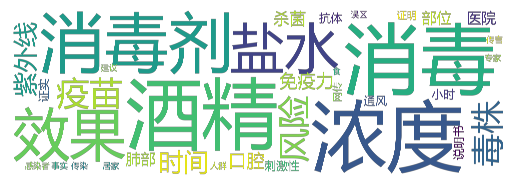

In [48]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

words ='消毒 酒精 浓度 消毒剂 效果 盐水 疫苗 毒株 风险 时间 紫外线 免疫力 口腔 杀菌 部位 医院 肺部 刺激性 抗体 通风 小时 证实 说明书 证明 网传 感染者 建议 误区 居家 专家 传染 人群 传言 事实 食'
# 创建WordCloud对象并指定字体路径
font_path = "/Users/tianyc/Downloads/weuruan/msyh.ttf"  # 替换为您的字体文件路径
wordcloud = WordCloud(scale=64,font_path=font_path, width=300, height=100, mode="RGBA", background_color=None).generate(words)

# 显示词云图
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud1.png')  # 保存词云图到本地
plt.show()

In [4]:
conda install wordcloud

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.5.0
  latest version: 23.7.3

Please update conda by running

    $ conda update -n base -c https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.3



## Package Plan ##

  environment location: /Users/tianyc/anaconda3

  added / updated specs:
    - wordcloud


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.05.30 |       hca03da5_0         121 KB  https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
    certifi-2023.7.22          |  py310hca03da5_0         154 KB  https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
    conda-23.7.3               |  py310hca03da5_0         1.0 MB  https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
    opens

### 2.2输出每篇文章对应主题 

In [121]:
import numpy as np

In [122]:
topics=lda.transform(tf)

In [123]:

topic = []
for t in topics:
    topic.append("Topic #"+str(list(t).index(np.max(t))))
data['概率最大的主题序号']=topic
data['每个主题对应概率']=list(topics)
data.to_excel("data_topic.xlsx",index=False)

In [124]:
topics[0]#第一篇文章对应各个主题的分数

array([0.00411543, 0.00411582, 0.99176876])

### 2.3可视化 

In [125]:
import pyLDAvis
import pyLDAvis.sklearn

In [126]:
pyLDAvis.enable_notebook()
pic = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

pyLDAvis.save_html(pic, 'lda_pass'+str(n_topics)+'.html')
pyLDAvis.display(pic)
#去工作路径下找保存好的html文件
#和视频里讲的不一样，目前这个代码不需要手动中断运行，可以快速出结果

### 2.4困惑度 

In [58]:
import matplotlib.pyplot as plt

In [53]:
plexs = []
scores = []
n_max_topics = 16
for i in range(1,n_max_topics):
    print(i)
    lda = LatentDirichletAllocation(n_components=i, max_iter=50,
                                    learning_method='batch',
                                    learning_offset=50,random_state=0)
    lda.fit(tf)
    plexs.append(lda.perplexity(tf))
    scores.append(lda.score(tf))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


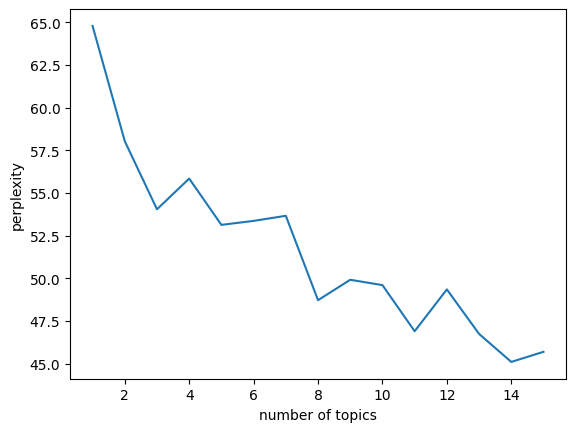

In [59]:
n_t=15#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t+1))
plt.plot(x,plexs[0:n_t])
plt.xlabel("number of topics")
plt.ylabel("perplexity")
plt.show()#主题困惑度不再下降时最优/最小困惑度所对应的Topic就是最优的主题数  

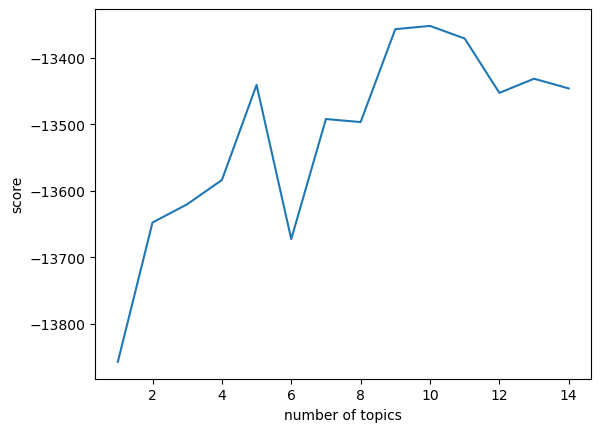

In [21]:
n_t=15#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t))
plt.plot(x,scores[1:n_t])
plt.xlabel("number of topics")
plt.ylabel("score")
plt.show()